|   Размер вектора 10е+4 |   Сумма на CPU |   Сумма на GPU |   Время на CPU, мкс |   Время на GPU, мкс |
|-----------------------:|---------------:|---------------:|--------------------:|--------------------:|
|                 100000 |    4.95924e+06 |    4.95924e+06 |            0.39978  |             26.5166 |
|                 150000 |    7.41318e+06 |    7.41318e+06 |            0.498486 |             38.5056 |
|                 200000 |    9.89012e+06 |    9.89012e+06 |            1.19987  |             36.8736 |
|                 250000 |    1.23574e+07 |    1.23574e+07 |            0.999618 |             43.9124 |
|                 300000 |    1.48519e+07 |    1.48519e+07 |            1.2002   |             53.0624 |
|                 350000 |    1.73346e+07 |    1.73346e+07 |            1.51441  |             52.8798 |
|                 400000 |    1.98027e+07 |    1.98027e+07 |            1.30124  |             55.8948 |
|                 450000 |    2.22954e+07 |    2.22954e

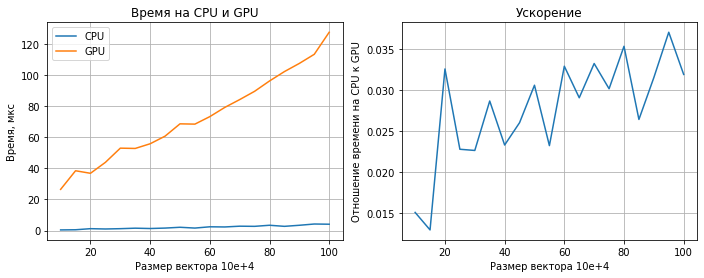

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import cuda, int32
from tabulate import tabulate

TPB = 32

@cuda.jit

def gpu_vecsum(V, sum):

    shr = cuda.shared.array(TPB, dtype=int32)
    thread = cuda.threadIdx.x
    block = cuda.blockIdx.x
    idx = block*TPB + thread
    shr[thread] = 0

    if idx < V.shape[0]:
        shr[thread] = V[idx]

        if thread == 0:
            S = 0
            for i in range (TPB):
                S +=shr[i]
            cuda.atomic.add(sum, 0, S)   

rows = []

for i in range(50000, 1000001, 50000):
    cpu_ts = 0
    gpu_ts = 0
    rng = np.random.RandomState(0)

    for m in range(100):

        V = rng.randint(100, size=i)
        sum = np.zeros(1, dtype=np.int32)

        start = time.time()
        cpu_vecsum = np.sum(V)
        cpu_t = time.time() - start
        cpu_ts +=cpu_t*10e+3
               
        start = time.time() 
        v = cuda.to_device(V)
        s = cuda.to_device(sum)
        gpu_vecsum[i, TPB](v, s)
        sum = s.copy_to_host()
        gpu_t = time.time() - start
        gpu_ts +=gpu_t*10e+3
                
        correct_result = np.array_equal(sum[0], cpu_vecsum)

    row = [i, cpu_vecsum, sum[0], cpu_ts/100, gpu_ts/100]
    rows.append(row)
del rows[0]

print(tabulate(rows, headers=['Размер вектора 10е+4', 'Сумма на CPU', 'Сумма на GPU', 'Время на CPU, мкс', 'Время на GPU, мкс'], tablefmt='pipe'))

vector = list(map(lambda x: x[0]/10000, rows))
cpu = list(map(lambda x: x[3], rows))
gpu = list(map(lambda x: x[4], rows))
acc = list(map(lambda x: x[3] / x[4], rows))

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Время на CPU и GPU")
plt.plot(vector, cpu, vector,  gpu)
plt.legend(['CPU','GPU'])
plt.xlabel("Размер вектора 10е+4")
plt.ylabel("Время, мкс")
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Ускорение")
plt.plot(vector, acc)
plt.xlabel("Размер вектора 10е+4")
plt.ylabel("Отношение времени на CPU к GPU")
plt.grid()

plt.show()